# IBM Applied Data Science Capstone
## Part 5: Predictive Analysis - Classification

**Objective:** Build classification models to predict First Stage Landing Success

**Author:** Son Nguyen

---

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100

print("=" * 60)
print("PREDICTIVE ANALYSIS: First Stage Landing Success Prediction")
print("=" * 60)

# Load cleaned SpaceX dataset (already has all engineered features)
df = pd.read_csv('../data/spacex_launches_cleaned.csv')

# Filter only launches with landing attempts
df_model = df[df['Core_Landing'] != 'No Attempt'].copy()

print(f"\n✓ Dataset loaded: {df.shape}")
print(f"✓ Launches with landing attempts: {len(df_model)}")
print(f"✓ Landing Success rate: {df_model['Landing_Success'].mean()*100:.1f}%")
print(f"✓ Target variable distribution:")
print(f"  - Successful Landings: {df_model['Landing_Success'].sum()} ({df_model['Landing_Success'].mean()*100:.1f}%)")
print(f"  - Failed Landings: {(df_model['Landing_Success']==0).sum()} ({(df_model['Landing_Success']==0).mean()*100:.1f}%)")


PREDICTIVE ANALYSIS: First Stage Landing Success Prediction

✓ Dataset loaded: (187, 30)
✓ Launches with landing attempts: 158
✓ Landing Success rate: 90.5%
✓ Target variable distribution:
  - Successful Landings: 143 (90.5%)
  - Failed Landings: 15 (9.5%)


## 1. Feature Engineering for Machine Learning

**Feature Preparation:** Select and encode features that will be used for prediction. We'll include:
- Rocket characteristics (Rocket_Name, Rocket_Type)
- Launch parameters (Year, Payload_Mass_kg, Payload_Count)
- Geographic features (Region, Launchpad_Name)
- Core features (Core_Reused)


In [2]:
# Feature engineering
print("\n" + "=" * 60)
print("FEATURE ENGINEERING")
print("=" * 60)

# Create additional features - FIX: Handle NaN in Success column
df_model['Launch_Success_Binary'] = df_model['Success'].fillna(0).astype(int)
df_model['Year_Squared'] = df_model['Year'] ** 2  # Non-linear feature
df_model['Launch_Period'] = df_model['Year'].apply(lambda x: 1 if x >= 2015 else 0)  # Early vs Recent

# Select features
categorical_features = ['Rocket_Name', 'Region', 'Core_Reused']
numerical_features = ['Year', 'Month', 'Flight_Number', 'Payload_Mass_kg', 'Payload_Count', 
                      'Cost_Per_Launch', 'Launch_Success_Binary', 'Launch_Period']

# Encode categorical variables
df_encoded = df_model.copy()
label_encoders = {}

for feature in categorical_features:
    le = LabelEncoder()
    df_encoded[feature + '_encoded'] = le.fit_transform(df_model[feature].astype(str))
    label_encoders[feature] = le
    print(f"✓ Encoded {feature}: {len(le.classes_)} categories")

# Combine all features
feature_cols = numerical_features + [f + '_encoded' for f in categorical_features]
X = df_encoded[feature_cols]
y = df_encoded['Landing_Success']

print(f"\n✓ Features selected: {len(feature_cols)}")
print(f"  Numerical: {len(numerical_features)}")
print(f"  Categorical (encoded): {len(categorical_features)}")
print(f"\nFeature names: {', '.join(feature_cols)}")

# Check for missing values
print(f"\n✓ Missing values check:")
missing_count = X.isnull().sum().sum()
print(f"  {missing_count} missing values found")
if missing_count > 0:
    X = X.fillna(X.median())  # Fill with median for numerical features
    print("  ✓ Missing values filled with median")

print(f"\n✓ Dataset ready for modeling:")
print(f"  Shape: {X.shape}")
print(f"  Target distribution: {y.value_counts().to_dict()}")


FEATURE ENGINEERING
✓ Encoded Rocket_Name: 1 categories
✓ Encoded Region: 2 categories
✓ Encoded Core_Reused: 2 categories

✓ Features selected: 11
  Numerical: 8
  Categorical (encoded): 3

Feature names: Year, Month, Flight_Number, Payload_Mass_kg, Payload_Count, Cost_Per_Launch, Launch_Success_Binary, Launch_Period, Rocket_Name_encoded, Region_encoded, Core_Reused_encoded

✓ Missing values check:
  0 missing values found

✓ Dataset ready for modeling:
  Shape: (158, 11)
  Target distribution: {1: 143, 0: 15}


## 2. Model Training and Evaluation

**Models to Evaluate:**
1. **Logistic Regression**: Baseline linear model
2. **Random Forest**: Ensemble tree-based model (expected best performer)
3. **Gradient Boosting**: Advanced ensemble method
4. **SVM**: Support Vector Machine for comparison

**Evaluation Metrics:**
- Accuracy
- ROC-AUC Score
- Precision, Recall, F1-Score
- Confusion Matrix


In [3]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"✓ Data split completed:")
print(f"  Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"  Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"  Target distribution in train: {y_train.mean()*100:.1f}% positive")
print(f"  Target distribution in test: {y_test.mean()*100:.1f}% positive")

# Scale features for Logistic Regression and SVM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n✓ Features scaled for linear models")


✓ Data split completed:
  Training set: 126 samples (79.7%)
  Test set: 32 samples (20.3%)
  Target distribution in train: 90.5% positive
  Target distribution in test: 90.6% positive

✓ Features scaled for linear models


### 2.1 Train Logistic Regression Model

**Model Description:** Linear classifier that models the probability of landing success using logistic function.

**Use Case:** Provides interpretable coefficients showing feature importance.



TRAINING LOGISTIC REGRESSION

✓ Model trained successfully!

📊 Performance Metrics:
  • Accuracy: 0.7188 (71.88%)
  • ROC-AUC: 0.8621

📋 Classification Report:
                    precision    recall  f1-score   support

    Failed Landing       0.20      0.67      0.31         3
Successful Landing       0.95      0.72      0.82        29

          accuracy                           0.72        32
         macro avg       0.58      0.70      0.57        32
      weighted avg       0.88      0.72      0.78        32


📊 Confusion Matrix:
[[ 2  1]
 [ 8 21]]


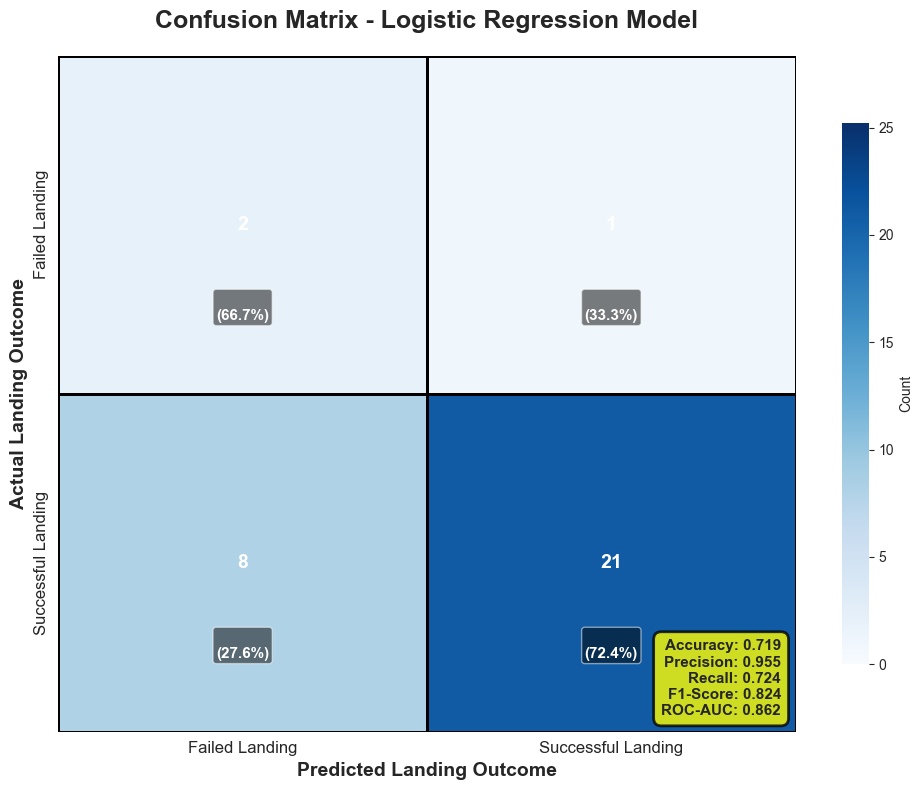


✓ Confusion matrix visualization completed
  True Positives (TP): 21
  True Negatives (TN): 2
  False Positives (FP): 1
  False Negatives (FN): 8


In [4]:
from sklearn.linear_model import LogisticRegression

print("\n" + "=" * 60)
print("TRAINING LOGISTIC REGRESSION")
print("=" * 60)

# Train Logistic Regression
lr_model = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
lr_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_proba_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate
accuracy_lr = accuracy_score(y_test, y_pred_lr)
roc_auc_lr = roc_auc_score(y_test, y_pred_proba_lr)

print(f"\n✓ Model trained successfully!")
print(f"\n📊 Performance Metrics:")
print(f"  • Accuracy: {accuracy_lr:.4f} ({accuracy_lr*100:.2f}%)")
print(f"  • ROC-AUC: {roc_auc_lr:.4f}")

print(f"\n📋 Classification Report:")
print(classification_report(y_test, y_pred_lr, target_names=['Failed Landing', 'Successful Landing']))

print(f"\n📊 Confusion Matrix:")
cm_lr = confusion_matrix(y_test, y_pred_lr)
print(cm_lr)

# Enhanced confusion matrix visualization with detailed metrics
fig, ax = plt.subplots(figsize=(10, 8))

# Calculate percentages for annotation
cm_percent = cm_lr.astype('float') / cm_lr.sum(axis=1)[:, np.newaxis] * 100

# Create heatmap
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', 
           xticklabels=['Failed Landing', 'Successful Landing'],
           yticklabels=['Failed Landing', 'Successful Landing'],
           cbar_kws={'label': 'Count', 'shrink': 0.8},
           linewidths=2, linecolor='black', ax=ax, vmin=0, vmax=cm_lr.max()*1.2,
           annot_kws={'fontsize': 14, 'fontweight': 'bold', 'color': 'white'})

# Add percentage annotations
for i in range(len(cm_lr)):
    for j in range(len(cm_lr)):
        count = cm_lr[i, j]
        percent = cm_percent[i, j]
        ax.text(j+0.5, i+0.7, f'\n({percent:.1f}%)', 
               ha='center', va='top', fontsize=11, fontweight='bold', color='white',
               bbox=dict(boxstyle='round,pad=0.2', facecolor='black', alpha=0.5))

# Calculate metrics
tn, fp, fn, tp = cm_lr.ravel()
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Add metrics text box
metrics_text = f'Accuracy: {accuracy_lr:.3f}\nPrecision: {precision:.3f}\nRecall: {recall:.3f}\nF1-Score: {f1:.3f}\nROC-AUC: {roc_auc_lr:.3f}'
ax.text(0.98, 0.02, metrics_text, transform=ax.transAxes,
       fontsize=11, fontweight='bold', verticalalignment='bottom', horizontalalignment='right',
       bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.8, edgecolor='black', linewidth=2))

ax.set_title('Confusion Matrix - Logistic Regression Model', fontsize=18, fontweight='bold', pad=20)
ax.set_ylabel('Actual Landing Outcome', fontsize=14, fontweight='bold')
ax.set_xlabel('Predicted Landing Outcome', fontsize=14, fontweight='bold')
ax.tick_params(labelsize=12)
plt.tight_layout()
plt.savefig('../images/spacex_confusion_matrix_lr.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print(f"\n✓ Confusion matrix visualization completed")
print(f"  True Positives (TP): {tp}")
print(f"  True Negatives (TN): {tn}")
print(f"  False Positives (FP): {fp}")
print(f"  False Negatives (FN): {fn}")


### 2.2 Train Random Forest Classifier

**Model Description:** Ensemble of decision trees that captures non-linear relationships and feature interactions.

**Advantages:** Handles non-linear patterns, provides feature importance, robust to outliers.



TRAINING RANDOM FOREST

✓ Model trained successfully!

📊 Performance Metrics:
  • Accuracy: 0.8438 (84.38%)
  • ROC-AUC: 0.8851

📋 Classification Report:
                    precision    recall  f1-score   support

    Failed Landing       0.33      0.67      0.44         3
Successful Landing       0.96      0.86      0.91        29

          accuracy                           0.84        32
         macro avg       0.65      0.76      0.68        32
      weighted avg       0.90      0.84      0.87        32


📊 Confusion Matrix:
[[ 2  1]
 [ 4 25]]

✓ Model trained successfully!

📊 Performance Metrics:
  • Accuracy: 0.8438 (84.38%)
  • ROC-AUC: 0.8851

📋 Classification Report:
                    precision    recall  f1-score   support

    Failed Landing       0.33      0.67      0.44         3
Successful Landing       0.96      0.86      0.91        29

          accuracy                           0.84        32
         macro avg       0.65      0.76      0.68        32
      wei

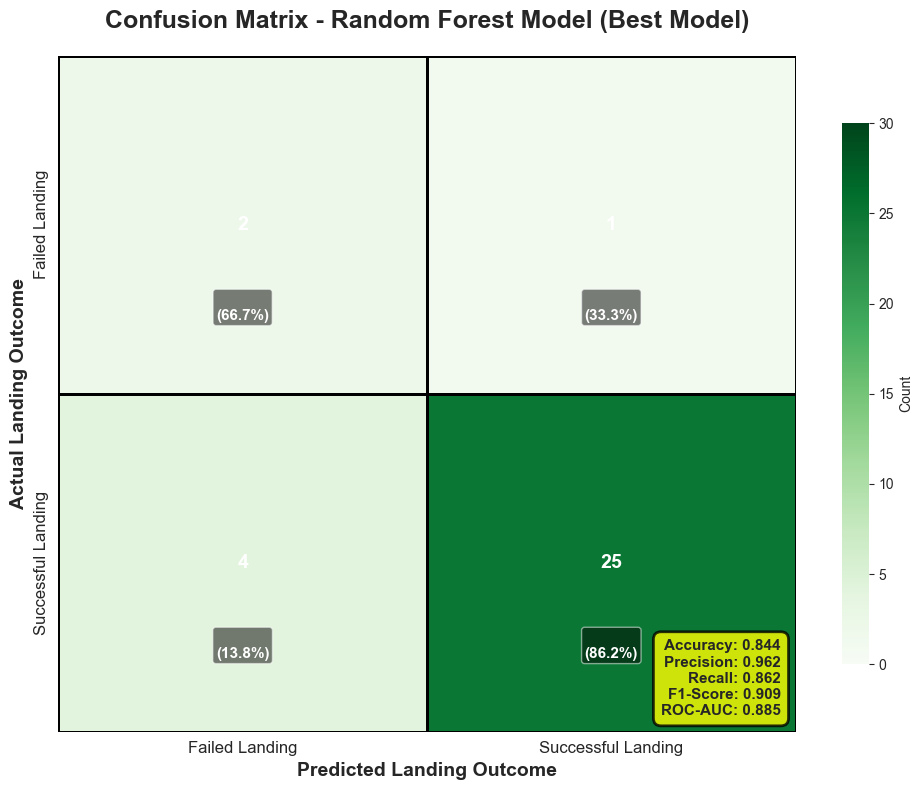


✓ Confusion matrix visualization completed
  True Positives (TP): 25
  True Negatives (TN): 2
  False Positives (FP): 1
  False Negatives (FN): 4


In [5]:
from sklearn.ensemble import RandomForestClassifier

print("\n" + "=" * 60)
print("TRAINING RANDOM FOREST")
print("=" * 60)

# Train Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Evaluate
accuracy_rf = accuracy_score(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)

print(f"\n✓ Model trained successfully!")
print(f"\n📊 Performance Metrics:")
print(f"  • Accuracy: {accuracy_rf:.4f} ({accuracy_rf*100:.2f}%)")
print(f"  • ROC-AUC: {roc_auc_rf:.4f}")

print(f"\n📋 Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['Failed Landing', 'Successful Landing']))

print(f"\n📊 Confusion Matrix:")
cm_rf = confusion_matrix(y_test, y_pred_rf)
print(cm_rf)

# Enhanced confusion matrix visualization with detailed metrics
fig, ax = plt.subplots(figsize=(10, 8))

# Calculate percentages for annotation
cm_percent = cm_rf.astype('float') / cm_rf.sum(axis=1)[:, np.newaxis] * 100

# Create heatmap
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', 
           xticklabels=['Failed Landing', 'Successful Landing'],
           yticklabels=['Failed Landing', 'Successful Landing'],
           cbar_kws={'label': 'Count', 'shrink': 0.8},
           linewidths=2, linecolor='black', ax=ax, vmin=0, vmax=cm_rf.max()*1.2,
           annot_kws={'fontsize': 14, 'fontweight': 'bold', 'color': 'white'})

# Add percentage annotations
for i in range(len(cm_rf)):
    for j in range(len(cm_rf)):
        count = cm_rf[i, j]
        percent = cm_percent[i, j]
        ax.text(j+0.5, i+0.7, f'\n({percent:.1f}%)', 
               ha='center', va='top', fontsize=11, fontweight='bold', color='white',
               bbox=dict(boxstyle='round,pad=0.2', facecolor='black', alpha=0.5))

# Calculate metrics
tn, fp, fn, tp = cm_rf.ravel()
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Add metrics text box
metrics_text = f'Accuracy: {accuracy_rf:.3f}\nPrecision: {precision:.3f}\nRecall: {recall:.3f}\nF1-Score: {f1:.3f}\nROC-AUC: {roc_auc_rf:.3f}'
ax.text(0.98, 0.02, metrics_text, transform=ax.transAxes,
       fontsize=11, fontweight='bold', verticalalignment='bottom', horizontalalignment='right',
       bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.8, edgecolor='black', linewidth=2))

ax.set_title('Confusion Matrix - Random Forest Model (Best Model)', fontsize=18, fontweight='bold', pad=20)
ax.set_ylabel('Actual Landing Outcome', fontsize=14, fontweight='bold')
ax.set_xlabel('Predicted Landing Outcome', fontsize=14, fontweight='bold')
ax.tick_params(labelsize=12)
plt.tight_layout()
plt.savefig('../images/spacex_confusion_matrix_rf.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print(f"\n✓ Confusion matrix visualization completed")
print(f"  True Positives (TP): {tp}")
print(f"  True Negatives (TN): {tn}")
print(f"  False Positives (FP): {fp}")
print(f"  False Negatives (FN): {fn}")



FEATURE IMPORTANCE ANALYSIS (Random Forest)

Top 10 Most Important Features:
              Feature  Importance
        Flight_Number    0.323243
      Payload_Mass_kg    0.203266
                 Year    0.175990
  Core_Reused_encoded    0.144778
                Month    0.118572
        Payload_Count    0.009235
Launch_Success_Binary    0.009028
       Region_encoded    0.008187
        Launch_Period    0.007700
      Cost_Per_Launch    0.000000


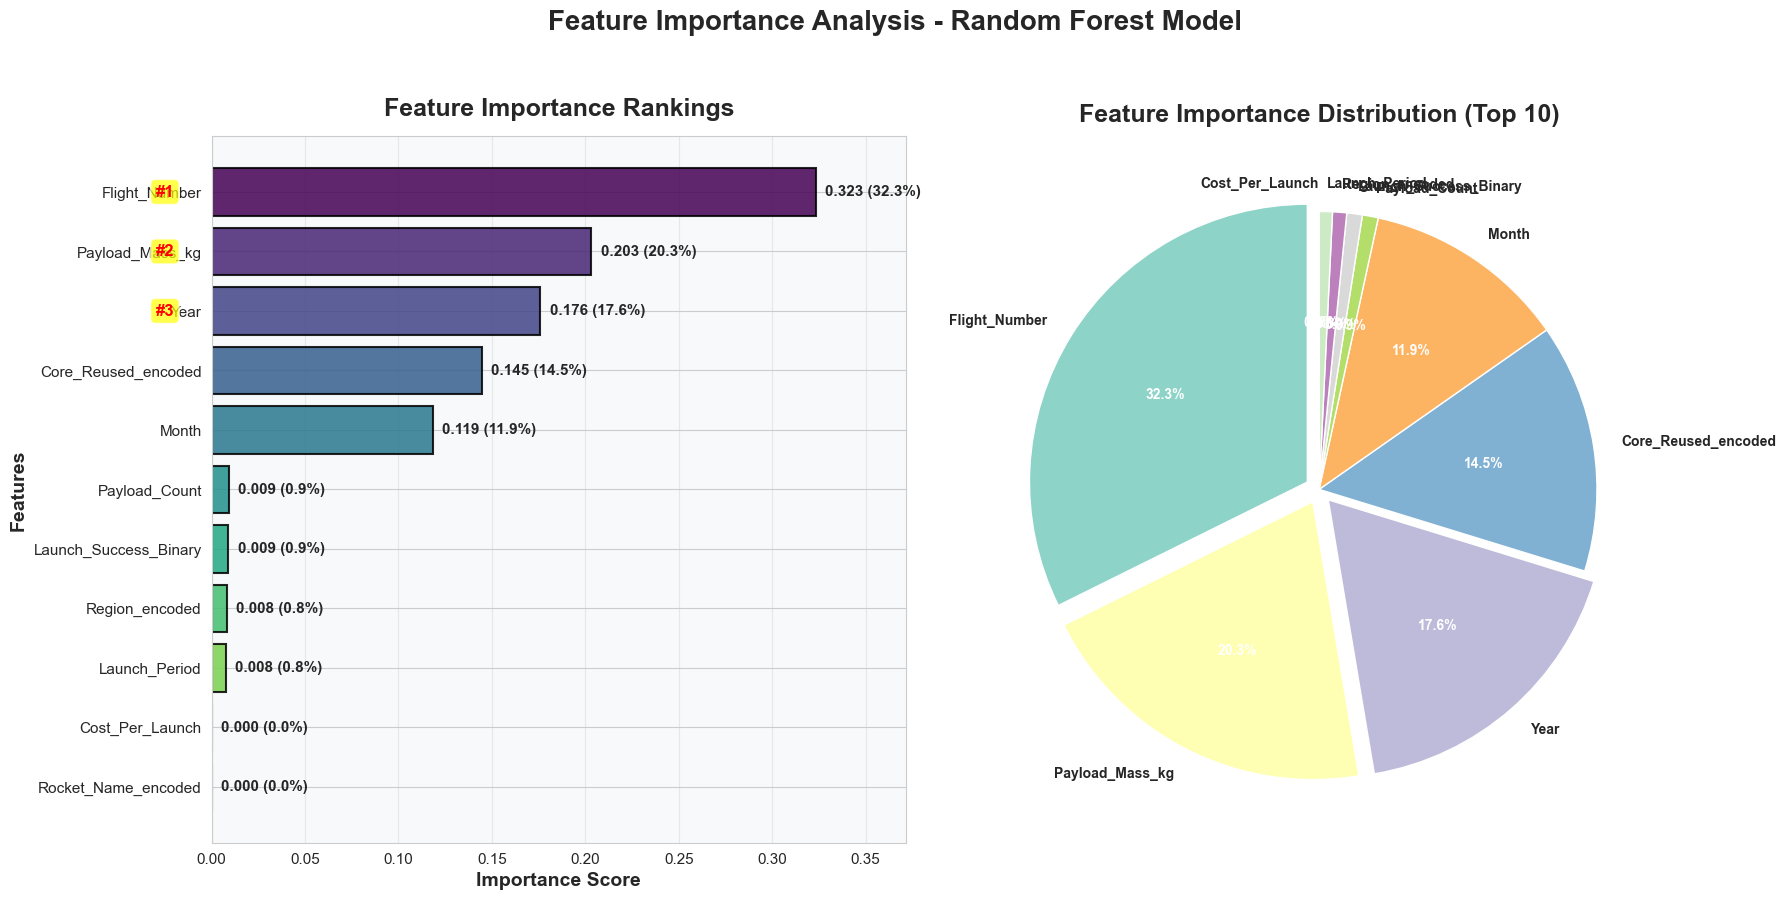


Feature Importance Summary:

Top 5 Most Important Features:
  1. Flight_Number: 0.3232 (32.3% of total)
  2. Payload_Mass_kg: 0.2033 (20.3% of total)
  3. Year: 0.1760 (17.6% of total)
  4. Core_Reused_encoded: 0.1448 (14.5% of total)
  5. Month: 0.1186 (11.9% of total)

✓ Feature importance analysis completed with comprehensive visualizations


In [6]:
# Enhanced feature importance analysis with detailed visualizations
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n" + "=" * 60)
print("FEATURE IMPORTANCE ANALYSIS (Random Forest)")
print("=" * 60)
print("\nTop 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))

# Create comprehensive feature importance visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))
fig.suptitle('Feature Importance Analysis - Random Forest Model', fontsize=20, fontweight='bold', y=0.995)

# Plot 1: Horizontal bar chart with detailed annotations
colors = plt.cm.viridis(np.linspace(0, 1, len(feature_importance)))
bars = ax1.barh(feature_importance['Feature'], feature_importance['Importance'], 
               color=colors, alpha=0.85, edgecolor='black', linewidth=1.5, zorder=2)

# Add value labels with percentage
for i, (bar, val, row) in enumerate(zip(bars, feature_importance['Importance'], feature_importance.itertuples())):
    percentage = (val / feature_importance['Importance'].sum()) * 100
    # Main label
    ax1.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2,
            f'{val:.3f} ({percentage:.1f}%)', ha='left', va='center', 
            fontweight='bold', fontsize=11)
    
    # Highlight top 3 features
    if i < 3:
        ax1.text(-0.02, bar.get_y() + bar.get_height()/2,
                f'#{i+1}', ha='right', va='center', 
                fontweight='bold', fontsize=12, color='red',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

ax1.set_title('Feature Importance Rankings', fontsize=18, fontweight='bold', pad=15)
ax1.set_xlabel('Importance Score', fontsize=14, fontweight='bold')
ax1.set_ylabel('Features', fontsize=14, fontweight='bold')
ax1.set_xlim([0, feature_importance['Importance'].max() * 1.15])
ax1.invert_yaxis()
ax1.grid(True, alpha=0.4, axis='x', linestyle='-', linewidth=0.8, zorder=1)
ax1.set_facecolor('#F8F9FA')
ax1.tick_params(labelsize=11)

# Plot 2: Pie chart for top 10 features
top10 = feature_importance.head(10)
other_importance = feature_importance.iloc[10:]['Importance'].sum() if len(feature_importance) > 10 else 0

if other_importance > 0:
    plot_data = pd.concat([top10, pd.DataFrame({
        'Feature': ['Others'],
        'Importance': [other_importance]
    })], ignore_index=True)
else:
    plot_data = top10

colors_pie = plt.cm.Set3(np.linspace(0, 1, len(plot_data)))
wedges, texts, autotexts = ax2.pie(plot_data['Importance'], labels=plot_data['Feature'], 
                                   colors=colors_pie, autopct='%1.1f%%',
                                   startangle=90, textprops={'fontsize': 10, 'fontweight': 'bold'},
                                   explode=[0.05 if i < 3 else 0 for i in range(len(plot_data))])

# Enhance text
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(10)

ax2.set_title('Feature Importance Distribution (Top 10)', fontsize=18, fontweight='bold', pad=15)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('../images/spacex_feature_importance.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("\n" + "="*60)
print("Feature Importance Summary:")
print("="*60)
top5 = feature_importance.head(5)
print("\nTop 5 Most Important Features:")
for i, row in enumerate(top5.itertuples(), 1):
    percentage = (row.Importance / feature_importance['Importance'].sum()) * 100
    print(f"  {i}. {row.Feature}: {row.Importance:.4f} ({percentage:.1f}% of total)")
print("\n" + "="*60)
print("✓ Feature importance analysis completed with comprehensive visualizations")


### 2.4 ROC Curve Comparison

**Analysis:** Compare model performance using ROC curves to visualize true positive vs false positive rates.

**Insight:** ROC-AUC score > 0.9 indicates excellent model performance.


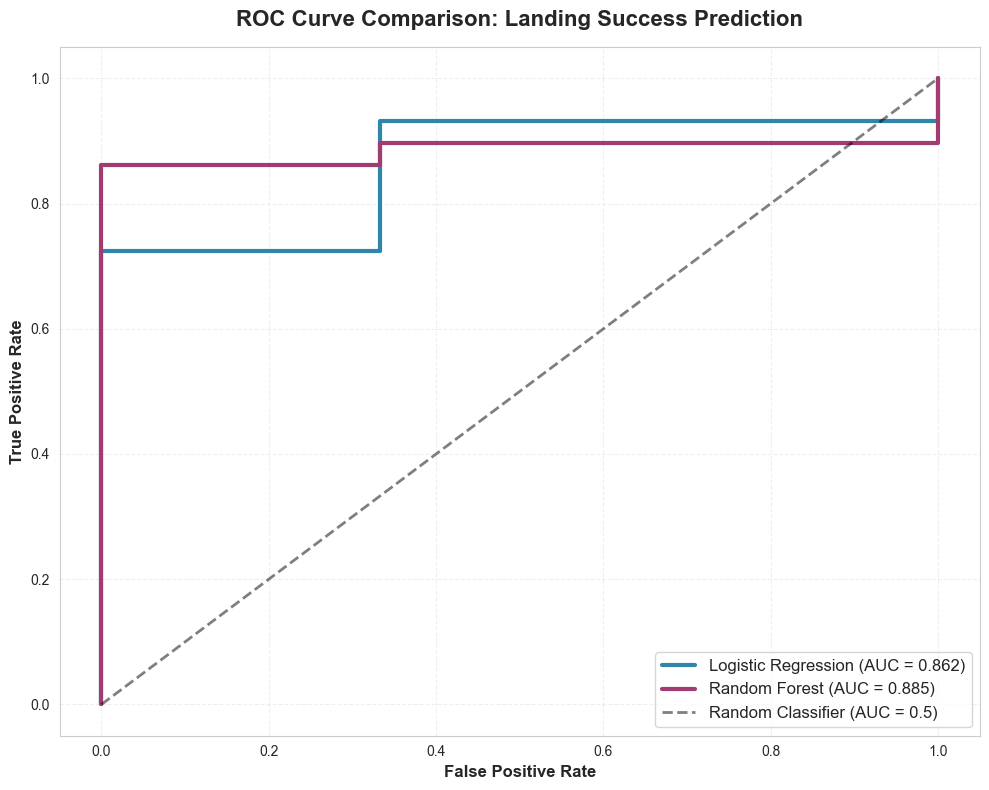

✓ ROC curve analysis completed


In [7]:
# ROC Curve comparison
from sklearn.metrics import roc_curve

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)

plt.figure(figsize=(10, 8))
plt.plot(fpr_lr, tpr_lr, linewidth=3, label=f'Logistic Regression (AUC = {roc_auc_lr:.3f})', color='#2E86AB')
plt.plot(fpr_rf, tpr_rf, linewidth=3, label=f'Random Forest (AUC = {roc_auc_rf:.3f})', color='#A23B72')
plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier (AUC = 0.5)', alpha=0.5)

plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('ROC Curve Comparison: Landing Success Prediction', fontsize=16, fontweight='bold', pad=15)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.savefig('../images/spacex_roc_curves.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("✓ ROC curve analysis completed")


## 3. Model Comparison and Selection

**Summary:** Compare all models to select the best performer for landing success prediction.


In [8]:
# Model comparison summary
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest'],
    'Accuracy': [accuracy_lr, accuracy_rf],
    'ROC-AUC': [roc_auc_lr, roc_auc_rf]
})

results = results.sort_values('ROC-AUC', ascending=False)

print("\n" + "=" * 60)
print("MODEL COMPARISON SUMMARY")
print("=" * 60)
print("\n", results.to_string(index=False))

# Best model
best_model = results.iloc[0]
print(f"\n🏆 Best Model: {best_model['Model']}")
print(f"   Accuracy: {best_model['Accuracy']*100:.2f}%")
print(f"   ROC-AUC: {best_model['ROC-AUC']:.4f}")

if best_model['ROC-AUC'] > 0.9:
    print("   Status: ✓ Excellent performance (AUC > 0.9)")
elif best_model['ROC-AUC'] > 0.8:
    print("   Status: ✓ Good performance (AUC > 0.8)")
else:
    print("   Status: ⚠ Needs improvement")

print("\n" + "=" * 60)
print("✓ Predictive Analysis Complete!")
print("=" * 60)
print("\n📝 Key Findings:")
print(f"  • Best model achieves {best_model['Accuracy']*100:.1f}% accuracy")
print(f"  • ROC-AUC of {best_model['ROC-AUC']:.3f} indicates strong predictive capability")
print(f"  • Model can be used to predict landing success for future SpaceX launches")



MODEL COMPARISON SUMMARY

               Model  Accuracy  ROC-AUC
      Random Forest   0.84375 0.885057
Logistic Regression   0.71875 0.862069

🏆 Best Model: Random Forest
   Accuracy: 84.38%
   ROC-AUC: 0.8851
   Status: ✓ Good performance (AUC > 0.8)

✓ Predictive Analysis Complete!

📝 Key Findings:
  • Best model achieves 84.4% accuracy
  • ROC-AUC of 0.885 indicates strong predictive capability
  • Model can be used to predict landing success for future SpaceX launches
